In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

df = pd.read_csv(url)

print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB
None
(1462, 9)


,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [2]:

import numpy as np
from sklearn.model_selection import train_test_split

df_processed = df.copy()

categorical_columns = ['lead_source', 'industry', 'employment_status', 'location']
numerical_columns = ['annual_income']

for col in categorical_columns:
    df_processed[col] = df_processed[col].fillna('NA')

for col in numerical_columns:
    df_processed[col] = df_processed[col].fillna(0.0)

df_train, df_temp = train_test_split(df_processed, test_size=0.4, random_state=1)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

df_full_train = pd.concat([df_train, df_val]).reset_index(drop=True)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values
y_full_train = df_full_train.converted.values

df_train = df_train.drop('converted', axis=1)
df_val = df_val.drop('converted', axis=1)
df_test = df_test.drop('converted', axis=1)
df_full_train = df_full_train.drop('converted', axis=1)

print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

Train size: 877
Validation size: 292
Test size: 293


In [3]:
#Q1
from sklearn.metrics import roc_auc_score

numerical_vars = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']

auc_scores = {}

for var in numerical_vars:
    scores = df_train[var].values
    auc = roc_auc_score(y_train, scores)

    if auc < 0.5:
        scores = -scores
        auc = roc_auc_score(y_train, scores)

    auc_scores[var] = auc

for var, score in auc_scores.items():
    print(f"{var}: {score:.4f}")

best_var = max(auc_scores, key=auc_scores.get)
print(f"\nHighest AUC: {best_var}")

lead_score: 0.6111
number_of_courses_viewed: 0.7652
interaction_count: 0.7272
annual_income: 0.5446

Highest AUC: number_of_courses_viewed


In [4]:
#Q2
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred_val = model.predict_proba(X_val)[:, 1]

auc_val = roc_auc_score(y_val, y_pred_val)
print(f"Validation AUC: {auc_val:.3f}")

Validation AUC: 0.794


Precision and Recall intersect at: 0.590


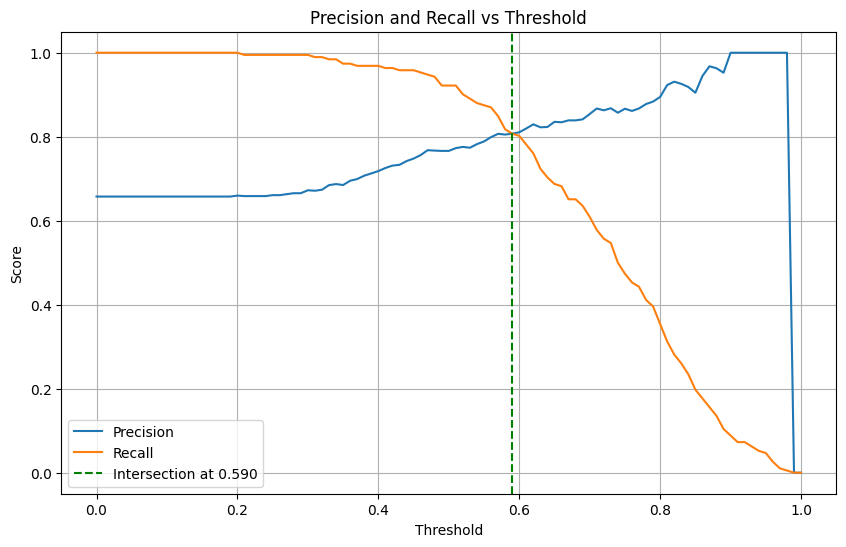

In [5]:
#Q3
import matplotlib.pyplot as plt

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

for t in thresholds:
    y_pred_binary = (y_pred_val >= t).astype(int)

    true_positive = ((y_pred_binary == 1) & (y_val == 1)).sum()
    false_positive = ((y_pred_binary == 1) & (y_val == 0)).sum()
    false_negative = ((y_pred_binary == 0) & (y_val == 1)).sum()

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)

intersection_threshold = None
min_diff = float('inf')

for i, t in enumerate(thresholds):
    diff = abs(precisions[i] - recalls[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = t

print(f"Precision and Recall intersect at: {intersection_threshold:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.axvline(x=intersection_threshold, color='green', linestyle='--', label=f'Intersection at {intersection_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

Max F1: 0.8485 at threshold: 0.470


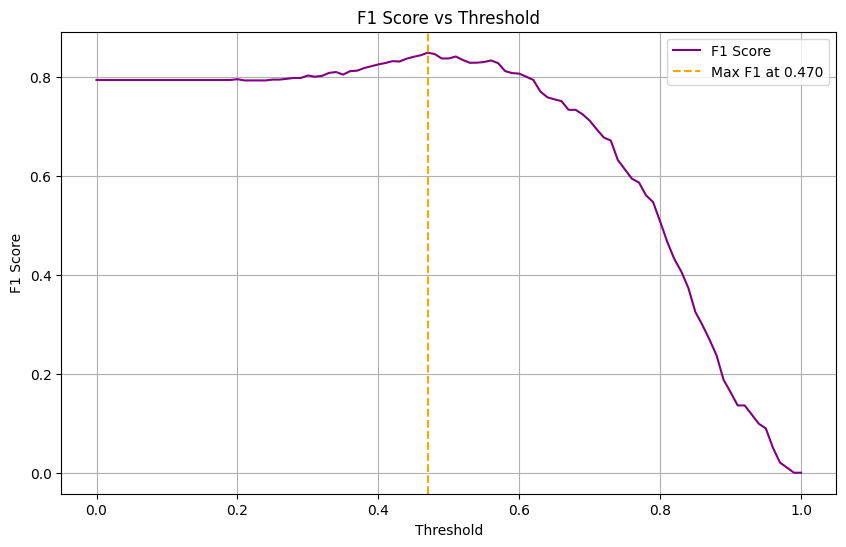

In [6]:
#Q4
f1_scores = []

for i, t in enumerate(thresholds):
    p = precisions[i]
    r = recalls[i]

    if p + r > 0:
        f1 = 2 * (p * r) / (p + r)
    else:
        f1 = 0

    f1_scores.append(f1)

max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"Max F1: {max_f1_score:.4f} at threshold: {max_f1_threshold:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='purple')
plt.axvline(x=max_f1_threshold, color='orange', linestyle='--', label=f'Max F1 at {max_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#Q5
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = y_full_train[train_idx]
    y_val_fold = y_full_train[val_idx]

    train_dict_fold = df_train_fold.to_dict(orient='records')
    val_dict_fold = df_val_fold.to_dict(orient='records')

    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dict_fold)
    X_val_fold = dv_fold.transform(val_dict_fold)

    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)

    y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc_fold)

print("CV scores:", [f"{score:.4f}" for score in scores])
print(f"Mean: {np.mean(scores):.4f}")
print(f"Std: {np.std(scores):.4f}")

CV scores: ['0.8067', '0.8068', '0.8648', '0.8334', '0.8154']
Mean: 0.8254
Std: 0.0220


In [8]:
#Q6
C_values = [0.000001, 0.001, 1]
cv_scores = {}

for C in C_values:
    fold_scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = y_full_train[train_idx]
        y_val_fold = y_full_train[val_idx]

        train_dict_fold = df_train_fold.to_dict(orient='records')
        val_dict_fold = df_val_fold.to_dict(orient='records')

        dv_fold = DictVectorizer(sparse=False)
        X_train_fold = dv_fold.fit_transform(train_dict_fold)
        X_val_fold = dv_fold.transform(val_dict_fold)

        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model_fold.fit(X_train_fold, y_train_fold)

        y_pred_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc_fold = roc_auc_score(y_val_fold, y_pred_fold)
        fold_scores.append(auc_fold)

    mean_score = np.mean(fold_scores)
    std_score = np.std(fold_scores)
    cv_scores[C] = (mean_score, std_score)

    print(f"C = {C}: Mean = {mean_score:.6f}, Std = {std_score:.6f}")

best_C = None
best_mean = -1
best_std = float('inf')

for C, (mean_score, std_score) in cv_scores.items():
    if mean_score > best_mean or (abs(mean_score - best_mean) < 1e-6 and std_score < best_std):
        best_mean = mean_score
        best_std = std_score
        best_C = C

print(f"\nBest C: {best_C}")

C = 1e-06: Mean = 0.543230, Std = 0.024862
C = 0.001: Mean = 0.864308, Std = 0.014313
C = 1: Mean = 0.825415, Std = 0.021987

Best C: 0.001
